In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_curve, auc

In [2]:

# Custom dataset class
class LensingDataset(Dataset):
    def __init__(self, root_dir, label, transform=None):
        self.root_dir = root_dir
        self.label = label
        self.transform = transform
        self.images = [os.path.join(root_dir, img) for img in os.listdir(root_dir)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = np.load(img_path)  # Shape: (3, 64, 64)
        image = torch.tensor(image, dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, self.label


In [12]:

# Define transformations
transform = transforms.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [13]:

# Reload datasets with proper transform
train_lenses = LensingDataset("train_lenses", 1, transform=transform)
train_nonlenses = LensingDataset("train_nonlenses", 0, transform=transform)
test_lenses = LensingDataset("test_lenses", 1, transform=transform)
test_nonlenses = LensingDataset("test_nonlenses", 0, transform=transform)


In [14]:
# Create imbalanced dataset handling
train_dataset = torch.utils.data.ConcatDataset([train_lenses, train_nonlenses])
labels = [1] * len(train_lenses) + [0] * len(train_nonlenses)
class_counts = [len(train_nonlenses), len(train_lenses)]
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
sample_weights = [class_weights[label] for label in labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)


In [15]:

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_dataset = torch.utils.data.ConcatDataset([test_lenses, test_nonlenses])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [16]:

# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [17]:

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.float32)       
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer)


Epoch 1, Loss: 0.2696
Epoch 2, Loss: 0.1689
Epoch 3, Loss: 0.1318
Epoch 4, Loss: 0.1030
Epoch 5, Loss: 0.0838


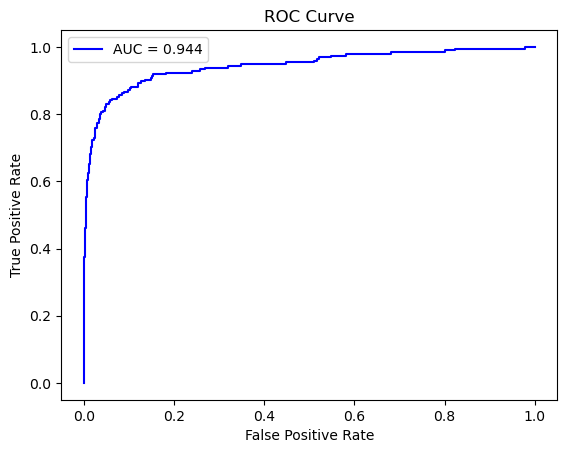

AUC Score: 0.944


In [18]:

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_scores = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.numpy()
            outputs = model(images).squeeze().cpu().numpy()
            y_true.extend(labels)
            y_scores.extend(outputs)
    
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.3f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    print(f"AUC Score: {auc_score:.3f}")

evaluate_model(model, test_loader)
